In this notebook, we will set up a simple dashboard of the number of covid cases/fatalities on a county by county level. We will play with Haskell to do this, using the Frames, Foldl, and Chart libraries in iHaskell.

In [1]:
{-# LANGUAGE DataKinds, FlexibleContexts, QuasiQuotes, TemplateHaskell, TypeApplications, TypeOperators, OverloadedStrings #-}

Line 1: Unused LANGUAGE pragma
Found:
{-# LANGUAGE DataKinds, FlexibleContexts, QuasiQuotes,
  TemplateHaskell, TypeApplications, TypeOperators, OverloadedStrings
  #-}
Why not:
{-# LANGUAGE DataKinds, FlexibleContexts, TypeOperators #-}

Import the data manipulation libraries:

In [2]:
import qualified Control.Foldl as L
import qualified Data.Foldable as F
import Data.Maybe (isNothing, fromJust)
import Control.Lens hiding (Identity)
import Frames
import Data.Text (pack, unpack)
import Data.Time

Next comes the charting library.

In [3]:
import Graphics.Rendering.Chart.Easy

Load the Data from the new-york times repository: https://github.com/nytimes/covid-19-data/blob/master/us-counties.csv

In [4]:
tableTypes "Covid" "us-counties.csv"

In [5]:
loadCovid :: IO (Frame Covid)
loadCovid = inCoreAoS (readTable "us-counties.csv")

In [6]:
cs <- loadCovid

Let's take a quick look at the first 5 elements of data:

In [7]:
mapM_ print (take 5 (F.toList cs))

{date :-> "2020-01-21", county :-> "Snohomish", state :-> "Washington", fips :-> 53061, cases :-> 1, deaths :-> 0}
{date :-> "2020-01-22", county :-> "Snohomish", state :-> "Washington", fips :-> 53061, cases :-> 1, deaths :-> 0}
{date :-> "2020-01-23", county :-> "Snohomish", state :-> "Washington", fips :-> 53061, cases :-> 1, deaths :-> 0}
{date :-> "2020-01-24", county :-> "Cook", state :-> "Illinois", fips :-> 17031, cases :-> 1, deaths :-> 0}
{date :-> "2020-01-24", county :-> "Snohomish", state :-> "Washington", fips :-> 53061, cases :-> 1, deaths :-> 0}

We'd like to graph the cases/fatalities over the dates, however, the date field is a Text field, which we will need to parse using the following function:

In [8]:
parseDate d = fromJust (parseTime defaultTimeLocale "%Y-%m-%d" (unpack d) :: Maybe UTCTime)

Set up a filter by county so we can restrict the data to specific counties:

In [9]:
-- First we set up a predicate to focus on the counties:
isCounty countyName = (== pack countyName) . view county

In [10]:
countyPrefilter countyName = L.prefilter (isCounty countyName)

We want to extract pairs of the form `(date, cases)`, and `(date, deaths)`, which we can do using the following functions:

In [11]:
getDate = parseDate . view date
getDateCases record = (getDate record, view cases record)
getDateDeaths record = (getDate record, view deaths record)

Now compose all three to get a list of such pairs:

In [12]:
countyDateCases countyName = L.fold (countyPrefilter countyName (L.premap getDateCases L.list))
countyDateDeaths countyName = L.fold (countyPrefilter countyName (L.premap getDateDeaths L.list))

This extracts the cases in Alameda county as follows:

In [13]:
take 5 $ countyDateDeaths "Alameda" cs

[(2020-03-01 00:00:00 UTC,0),(2020-03-02 00:00:00 UTC,0),(2020-03-03 00:00:00 UTC,0),(2020-03-04 00:00:00 UTC,0),(2020-03-05 00:00:00 UTC,0)]

Now let's graph it:

In [14]:
countyChart countyName = toRenderable $ do
    layout_title .= "Cases vs Deaths for " ++ countyName
    setColors [opaque blue, opaque red]
    plot ( line "Cases" [countyDateCases countyName cs])
    plot ( line "Deaths" [countyDateDeaths countyName cs])

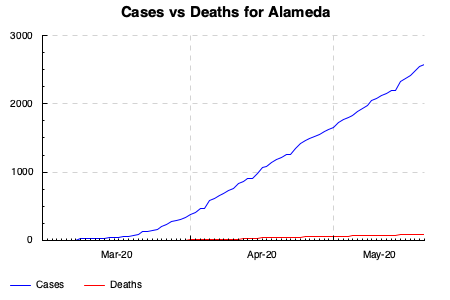

In [15]:
countyChart "Alameda"

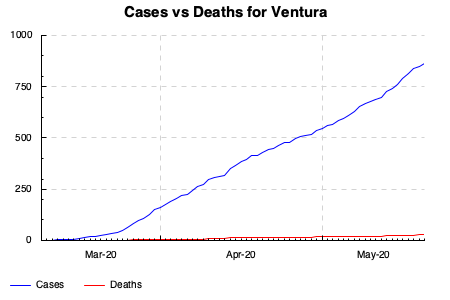

In [16]:
countyChart "Ventura"